## Assignment 1: Index Replication 
###### Pete Davis – pmd734 
###### (Worked With: Shan Ali, Dylan Nikol, Matthew Streichler, David Cruz)


In [2]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
%pylab inline
import statsmodels.api as sm
from patsy import dmatrices
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


C:\Users\19727\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
df = pd.read_csv('All123.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore').dt.to_period('M')
df.iloc[:5]
df = df.rename(columns = {'COMNAM':'Company','PRC':'Price', 'SHROUT':'Shares', 'CFACPR':'Price Adj', 'CFACSHR':'Shares Adj'})

In [4]:
df['Price Adjusted'] = df['Price'] / df['Price Adj']
df['Shares Adjusted'] = (df['Shares'] * df['Shares Adj']) * 1000
df['Mkt Cap'] = (df['Shares Adjusted'] * df['Price Adjusted']).replace([np.inf, -np.inf], np.nan)
df = df.dropna().reset_index(drop=True)
df = df.drop(["Price", "Shares", "Price Adj", "Shares Adj"], axis=1)
df

,PERMNO,date,EXCHCD,TICKER,Company,Price Adjusted,Shares Adjusted,Mkt Cap
0,10001,2009-12,2,EGAS,ENERGY INC,10.30000,4361000.0,4.491830e+07
1,10001,2010-01,2,EGAS,ENERGY INC,10.06000,4361000.0,4.387166e+07
2,10001,2010-02,2,EGAS,ENERGY INC,10.00840,4361000.0,4.364663e+07
3,10001,2010-03,2,EGAS,ENERGY INC,10.17000,4361000.0,4.435137e+07
4,10001,2010-04,2,EGAS,ENERGY INC,11.39000,6070000.0,6.913730e+07
...,...,...,...,...,...,...,...,...
688461,93436,2019-08,3,TSLA,TESLA INC,225.61000,179127000.0,4.041284e+10
688462,93436,2019-09,3,TSLA,TESLA INC,240.87000,180000000.0,4.335660e+10
688463,93436,2019-10,3,TSLA,TESLA INC,314.92001,180245000.0,5.676276e+10
688464,93436,2019-11,3,TSLA,TESLA INC,329.94000,180245000.0,5.947004e+10


In [5]:
df['date'][0].month

12

In [6]:
# all the different dates
dates = df['date'].unique()
dates

<PeriodArray>
['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
 '2010-07', '2010-08', '2010-09',
 ...
 '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
 '2019-10', '2019-11', '2019-12']
Length: 121, dtype: period[M]

## Replicate SP500

In [7]:
#### SP500 WEIGHTED BY THE MARKET CAP
def rebalance(newdf):
    newdf['Weight'] = newdf['Mkt Cap'] / newdf['Mkt Cap'].sum()
    return newdf

def reconstitute(newdf):
    newdf = newdf.sort_values(by = 'Mkt Cap', ascending = False)[0:505].reset_index(drop=True) 
    newdf = rebalance(newdf)
    return newdf

In [8]:
# reconstitue --> changing the list of the SP500 ANUALLY
# rebalance --> chaning the number (balance) of the SP500 MONTHLY
col = ['date','PERMNO', 'TICKER', 'Mkt Cap', 'Weight']
s_p = pd.DataFrame(np.zeros((0,len(col))), columns = col)
s_p500 = pd.DataFrame(np.zeros((505, len(col))), columns = col)
date_1 = 0


for date in dates:
    
    newdf = df[df['date'] == date][['date','PERMNO','TICKER','Price Adjusted','Shares Adjusted','Mkt Cap']]
    
    # check if about to be new year for reconstitution 
    if date.month % 12 == 0:
        s_p500 = reconstitute(newdf)
        constituents = s_p500[['PERMNO']]
        
    #check if quarter for rebalancing
    elif date.month % 3 == 0:
        newdf = newdf.merge(constituents)
        s_p500 = rebalance(newdf)
        
    #otherwise maintain weights
    else:
        cols = ['date','PERMNO','TICKER','Price Adjusted','Mkt Cap', 'Weight']
        newdf = newdf.merge(constituents, how = 'left')
        s_p500 = s_p500.drop(columns = ['date','Mkt Cap'])
        s_p500 = s_p500.merge(newdf[['date','PERMNO','Mkt Cap']], how = 'left', left_on = 'PERMNO', right_on ='PERMNO')[cols]
    
    # append to timeseries
    s_p = s_p.append(s_p500).reset_index(drop=True)

s_p
        
    
   

,date,PERMNO,TICKER,Mkt Cap,Weight,Price Adjusted,Shares Adjusted
0,2009-12,11850.0,XOM,3.226681e+11,0.027441,68.19000,4.731898e+09
1,2009-12,10107.0,MSFT,2.685593e+11,0.022839,30.48000,8.811000e+09
2,2009-12,55976.0,WMT,2.036537e+11,0.017319,53.45000,3.810172e+09
3,2009-12,14593.0,AAPL,1.909826e+11,0.016242,30.10457,6.343974e+09
4,2009-12,22111.0,JNJ,1.777136e+11,0.015113,64.41000,2.759100e+09
...,...,...,...,...,...,...,...
60602,2019-12,21792.0,CNP,1.369614e+10,0.000445,27.27000,5.022420e+08
60603,2019-12,59300.0,UDR,1.368558e+10,0.000444,46.70000,2.930530e+08
60604,2019-12,90305.0,EXR,1.367895e+10,0.000444,105.62000,1.295110e+08
60605,2019-12,32986.0,ATO,1.367589e+10,0.000444,111.86000,1.222590e+08


In [9]:

from pandas import Series, DataFrame
import pandas as pd
%pylab inline
### this is the the SP500 through every year
#s_p.sort_values(by='Weight', ascending = False)


##### need to get the sp500 for each month --> = mkt cap * weight
s_p['index_val'] = s_p['Weight'] * s_p['Price Adjusted']
#s_p500['Weight'].sum()
new_sp = s_p.groupby(['date'])[['index_val']].sum()
new_sp = new_sp.reset_index()
new_sp = new_sp.set_index('date')

# This is the index value for each month (120 periods)
new_sp

Populating the interactive namespace from numpy and matplotlib


C:\Users\19727\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,index_val
date,
2009-12,930.399732
2010-01,930.394103
2010-02,930.084746
2010-03,1285.572102
2010-04,1285.561203
...,...
2019-08,2832.698711
2019-09,2671.640370
2019-10,2671.633138


In [10]:
#Annual Return of SP500
closes = new_sp['index_val']
yesterdays_closes = closes.shift(1)
new_sp['return'] = (closes / yesterdays_closes - 1)
sp_annRet = (1 + (new_sp['return'].mean()))**12 - 1
sp_annRet

# ANNUAL standard deviation 
stdev_sp500 = new_sp['return'].std() * sqrt(12)
stdev_sp500

rf = .02

# Share ratio
sharpe = (sp_annRet - rf) / stdev_sp500
sharpe


# Add it to a data frame
metrics = pd.DataFrame(data = {'return': [sp_annRet], 'sd': [stdev_sp500], 'sharpe': [sharpe]})
metrics = metrics.rename({0:'My SP500'})
metrics

,return,sd,sharpe
My SP500,0.145297,0.222691,0.562649


## Mutual Fund

In [11]:
#LOAD IN MUTUAL
mutual = pd.read_csv('mutual.csv')
mutual['caldt'] = pd.to_datetime(mutual['caldt'], format='%Y%m%d', errors='ignore').dt.to_period('M')
mutual.rename(columns={"caldt":"date", "mtna":"month net assets", "mret":"month ret", "mnav":"month nav"}, inplace=True)
mutual['month nav'] = mutual['month nav'] * 10
mutual = mutual.drop_duplicates(subset = 'date', keep ='first')
mutual = mutual.set_index('date')
mutual['month ret'] = mutual['month ret'].astype(float)


# Calculate
mutual_ret= (1 + mutual['month ret'].mean())**12 - 1
mutual_sd = mutual['month ret'].std() * sqrt(12)
mutual_sharpe = (mutual_ret - rf) / mutual_sd

#Add it to the DF
mutual_metrics = pd.DataFrame(data = {'return': [mutual_ret], 'sd': [mutual_sd], 'sharpe': [mutual_sharpe]})
metrics = metrics.append(mutual_metrics.rename({0:"Mutual Fund"}))
metrics

,return,sd,sharpe
My SP500,0.145297,0.222691,0.562649
Mutual Fund,0.144832,0.124058,1.006236


## Actual SP500

In [12]:
## ADDING THE ACTUAL SP500
SP500_real = pd.read_csv('SP500.csv')
SP500_real['caldt'] = pd.to_datetime(SP500_real['caldt'], format='%Y%m%d', errors='ignore').dt.to_period('M')
SP500_real.rename(columns={"caldt":"date", 'spindx':'level','sprtrn':'return'}, inplace=True)
SP500_real = SP500_real.set_index('date')

# Calculations
SP_ret_real = (1 + (SP500_real['return'].mean()))**12 - 1
SP_sd_real = SP500_real['return'].std() * sqrt(12)
SP_sharpe = (SP_ret_real - rf) / SP_sd_real

# Add it the the DataFrame
SP_metrics = pd.DataFrame(data = {'return': [SP_ret_real], 'sd': [SP_sd_real], 'sharpe': [SP_sharpe]})
metrics = metrics.append(SP_metrics.rename({0:"Actual SP500"}))
metrics

,return,sd,sharpe
My SP500,0.145297,0.222691,0.562649
Mutual Fund,0.144832,0.124058,1.006236
Actual SP500,0.121668,0.124094,0.819283


## ETF (SPY)

In [13]:
spy = pd.read_csv('SPY.csv')
spy['date'] = pd.to_datetime(spy['date'], format='%Y%m%d', errors='ignore').dt.to_period('M')
spy = spy.rename(columns = {'COMNAM':'Company','PRC':'Price', 'SHROUT':'Shares', 'CFACPR':'Price Adj', 'CFACSHR':'Shares Adj'})
spy = spy.set_index('date')
spy['Price Adjusted'] = spy['Price'] / spy['Price Adj'] * 10
spy = spy.drop(["Price", "Shares", "Price Adj", "Shares Adj", 'PERMNO', 'TICKER', 'Company',], axis=1)


today = spy["Price Adjusted"]
yesterday = today.shift(1)
spy["return"] = (today - yesterday) / yesterday

# Annual return
spy_ret = (1 + spy["return"].mean())**12 - 1

# Calculating standard deviation - annual
spy_std = spy["return"].std() * sqrt(12)

# Calculating sharpe ratio
rf = 0.02
spy_sharpe = (spy_ret - rf) / spy_std


### Add Spy to the dataframe
spy_metrics = pd.DataFrame(data = {'return': [spy_ret], 'sd': [spy_std], 'sharpe': [spy_sharpe]})
metrics = metrics.append(spy_metrics.rename({0:"SPY (ETF)"}))
metrics

,return,sd,sharpe
My SP500,0.145297,0.222691,0.562649
Mutual Fund,0.144832,0.124058,1.006236
Actual SP500,0.121668,0.124094,0.819283
SPY (ETF),0.120438,0.124805,0.804758


## Final Comparison Metrics

In [14]:
metrics_4 = metrics
metrics_4

,return,sd,sharpe
My SP500,0.145297,0.222691,0.562649
Mutual Fund,0.144832,0.124058,1.006236
Actual SP500,0.121668,0.124094,0.819283
SPY (ETF),0.120438,0.124805,0.804758


## Plot Four - SP500
The ETF and the actual SP500 perfectly align.

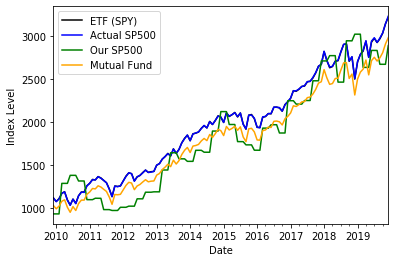

In [15]:
### Plot the four
spy['Price Adjusted'].plot(label = 'ETF (SPY)', color = 'black')
SP500_real['level'].plot(label='Actual SP500', color = 'blue')
new_sp['index_val'].plot(label='Our SP500', color = 'green')
mutual['month nav'].plot(label = 'Mutual Fund', color = 'orange')
xlabel('Date')
ylabel('Index Level')
legend(loc='best')

## Correlation Matrix

In [16]:
#SP500_real['level']
#new_sp['index_val']
#mutual['month nav']
#spy['Price Adjusted']

# Correlation matrix between my S&P 500, the actual S&P 500 Index, a Mutual Fund, and an ETF
sp_return_corr = pd.DataFrame(data={"My S&P 500":new_sp['index_val'], "Mutual Fund (VFIAX)":mutual['month nav'], "Actual S&P 500":SP500_real['level'], "ETF (SPY)":spy['Price Adjusted']})
sp_return_corr.corr()

,My S&P 500,Mutual Fund (VFIAX),Actual S&P 500,ETF (SPY)
My S&P 500,1.000000,0.954931,0.954969,0.954747
Mutual Fund (VFIAX),0.954931,1.000000,0.999986,0.999997
Actual S&P 500,0.954969,0.999986,1.000000,0.999985
ETF (SPY),0.954747,0.999997,0.999985,1.000000


In [55]:
# Load in data from DJIA constituent companies over the years
djia30 = pd.read_csv('DJIA 30.csv')
djia30['date'] = pd.to_datetime(djia30['date'], format='%Y%m%d', errors='ignore').dt.to_period('M')
djia30 = djia30.rename(columns = {'COMNAM':'Company','PRC':'Price', 'SHROUT':'Shares', 'CFACPR':'Price Adj', 'CFACSHR':'Shares Adj'})


djia30['Price Adjusted'] = djia30['Price'] / djia30['Price Adj']
djia30['Shares Adjusted'] = (djia30['Shares'] * djia30['Shares Adj']) * 1000
djia30 = djia30.drop(["Price Adj", "Shares Adj"], axis=1)
djia30

,PERMNO,date,TICKER,Company,Price,Shares,Price Adjusted,Shares Adjusted
0,10107,2009-12,MSFT,MICROSOFT CORP,30.4800,8811000.0,30.4800,8.811000e+09
1,10107,2010-01,MSFT,MICROSOFT CORP,28.1800,8770461.0,28.1800,8.770461e+09
2,10107,2010-02,MSFT,MICROSOFT CORP,28.6700,8770461.0,28.6700,8.770461e+09
3,10107,2010-03,MSFT,MICROSOFT CORP,29.2875,8762000.0,29.2875,8.762000e+09
4,10107,2010-04,MSFT,MICROSOFT CORP,30.5350,8763839.0,30.5350,8.763839e+09
...,...,...,...,...,...,...,...,...
3723,89006,2019-08,MDLZ,MONDELEZ INTERNATIONAL INC,55.2200,1442151.0,55.2200,1.442151e+09
3724,89006,2019-09,MDLZ,MONDELEZ INTERNATIONAL INC,55.3200,1440676.0,55.3200,1.440676e+09
3725,89006,2019-10,MDLZ,MONDELEZ INTERNATIONAL INC,52.4500,1439824.0,52.4500,1.439824e+09
3726,89006,2019-11,MDLZ,MONDELEZ INTERNATIONAL INC,52.5400,1439824.0,52.5400,1.439824e+09


## Replicate DJIA

In [80]:
#### DJIA WEIGHTED BY THE PRICE
def rebalance(newdf):
    newdf['Price Weight'] = newdf['Price Adjusted'] / newdf['Price Adjusted'].sum()
    return newdf

def reconstitute(newdf):
    newdf = newdf.sort_values(by = 'Price Adjusted', ascending = False)[0:30].reset_index(drop=True) 
    newdf = rebalance(newdf)
    return newdf

In [81]:
# reconstitue --> changing the list of the DJIA Annually
# rebalance --> chaning the number (balance) of the DJIA MONTHLY
col = ['date','PERMNO', 'TICKER']
djia = pd.DataFrame(np.zeros((0,len(col))), columns = col)
djia_ = pd.DataFrame(np.zeros((30, len(col))), columns = col)
date_1 = 0


for date in dates:
    
    newdf = djia30[djia30['date'] == date][['date','PERMNO','TICKER','Price Adjusted']]
    
    # check if about to be new year for reconstitution 
    if date.month % 12 == 0:
        djia_ = reconstitute(newdf)
        constituents = djia_[['PERMNO']]
        
    #check if quarter for rebalancing
    elif date.month % 3 == 0:
        newdf = newdf.merge(constituents)
        djia_ = rebalance(newdf)
        
    #otherwise maintain weights
    else:
        cols = ['date','PERMNO','TICKER','Price Adjusted', 'Price Weight']
        newdf = newdf.merge(constituents, how = 'left')
        djia_ = djia_.drop(columns = ['date'])
        djia_ = djia_.merge(newdf[['date','PERMNO']], how = 'left', left_on = 'PERMNO', right_on ='PERMNO')[cols]
    
    # append to timeseries
    djia = djia.append(djia_).reset_index(drop=True)

djia

,date,PERMNO,TICKER,Price Adjusted,Price Weight
0,2009-12,12490.0,IBM,130.89999,0.098287
1,2009-12,22592.0,MMM,82.67000,0.062073
2,2009-12,14541.0,CVX,76.99000,0.057808
3,2009-12,17830.0,UTX,69.41000,0.052117
4,2009-12,11850.0,XOM,68.19000,0.051201
...,...,...,...,...,...
3622,2019-12,59408.0,BAC,35.22000,0.010987
3623,2019-12,24643.0,ARNC,30.77000,0.009599
3624,2019-12,16347.0,AA,21.51000,0.006710
3625,2019-12,27828.0,HPQ,20.55000,0.006411


In [87]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

divisor = .152
new_djia = djia.groupby(['date'])['Price Adjusted'].sum() / divisor
new_djia = new_djia.to_frame()

# Calculate Return 
today = new_djia["Price Adjusted"]
yesterday = today.shift(1)
new_djia["return"] = (today - yesterday) / yesterday


# Annual return
our_djia_ret = (1 + new_djia["return"].mean())**12 - 1

# Calculating standard deviation - annual
our_djia_std = new_djia["return"].std() * sqrt(12)

# Calculating sharpe ratio
rf = 0.02
our_djia_sharpe = (our_djia_ret - rf) / our_djia_std

# Add it to a data frame
our_djia_metrics = pd.DataFrame(data = {'return': [our_djia_ret], 'sd': [our_djia_std], 'sharpe': [our_djia_sharpe]})
djia_metrics1 = our_djia_metrics.rename({0:'Our DJIA'})
djia_metrics1

Populating the interactive namespace from numpy and matplotlib


,return,sd,sharpe
Our DJIA,0.100301,0.126463,0.634979


## Actual DJIA

In [88]:
real_djia = pd.read_csv('DJIA.csv')
real_djia['datadate'] = pd.to_datetime(real_djia['datadate'], format='%Y%m%d', errors='ignore').dt.to_period('M')
real_djia = real_djia.set_index('datadate')
sp500_ = real_djia[real_djia['conm'] != 'Dow Jones Industrials-30 Stk']
real_djia = real_djia[real_djia['conm'] == 'Dow Jones Industrials-30 Stk']


# Calculate Return 
today = real_djia["prccm"]
yesterday = today.shift(1)
real_djia["return"] = (today - yesterday) / yesterday

# Annual return
djia_ret = (1 + real_djia["return"].mean())**12 - 1

# Calculating standard deviation - annual
djia_std = real_djia["return"].std() * sqrt(12)

# Calculating sharpe ratio
rf = 0.02
djia_sharpe = (djia_ret - rf) / djia_std

### Add to the dataframe
real_djia_metrics = pd.DataFrame(data = {'return': [djia_ret], 'sd': [djia_std], 'sharpe': [djia_sharpe]})
djia_metrics1 = djia_metrics1.append(real_djia_metrics.rename({0:"Actual DJIA"}))
djia_metrics1

,return,sd,sharpe
Our DJIA,0.100301,0.126463,0.634979
Actual DJIA,0.113861,0.120673,0.777812


## ETF

In [89]:
etf_djia = pd.read_csv('etf.csv')
etf_djia = etf_djia[etf_djia['tic'] == 'DIA']
etf_djia['datadate'] = pd.to_datetime(etf_djia['datadate'], format='%Y%m%d', errors='ignore').dt.to_period('M')
etf_djia = etf_djia.set_index('datadate')
etf_djia['Price Adjusted'] = etf_djia["prccm"] * 100



# Calculate Return 
today1 = etf_djia['Price Adjusted']
yesterday1 = today1.shift(1)
etf_djia["return"] = (today1 - yesterday1) / yesterday1

# Annual return
etf_djia_ret = (1 + etf_djia["return"].mean())**12 - 1

# Calculating standard deviation - annual
etf_djia_std = etf_djia["return"].std() * sqrt(12)

# Calculating sharpe ratio
rf = 0.02
etf_djia_sharpe = (etf_djia_ret - rf) / etf_djia_std

### Add to the dataframe
etf_djia_metrics = pd.DataFrame(data = {'return': [etf_djia_ret], 'sd': [etf_djia_std], 'sharpe': [etf_djia_sharpe]})
djia_metrics1 = djia_metrics1.append(etf_djia_metrics.rename({0:"ETF"}))
djia_metrics1

,return,sd,sharpe
Our DJIA,0.100301,0.126463,0.634979
Actual DJIA,0.113861,0.120673,0.777812
ETF,0.114020,0.121036,0.776788


## Mutual Fund

In [90]:
#LOAD IN MUTUAL
mutual = pd.read_csv('mutual.csv')

#rydhx mutual fund  ---> only have it since 2015
mutual = mutual[mutual['crsp_fundno'] == 86323].reset_index(drop=True)
mutual['caldt'] = pd.to_datetime(mutual['caldt'], format='%Y%m%d', errors='ignore').dt.to_period('M')
mutual.rename(columns={"caldt":"date", "mtna":"month net assets", "mret":"month ret", "mnav":"month nav"}, inplace=True)

#Scale the DJIA
mutual['month nav'] = mutual['month nav'] * 380

mutual = mutual.drop_duplicates(subset = 'date', keep ='first')
mutual = mutual.set_index('date')
mutual['month ret'] = mutual['month ret'].astype(float)

# Calculate
mutual_ret= (1 + mutual['month ret'].mean())**12 - 1
mutual_sd = mutual['month ret'].std() * sqrt(12)
mutual_sharpe = (mutual_ret - rf) / mutual_sd

#Add it to the DF
mutual_djia_metrics = pd.DataFrame(data = {'return': [mutual_ret], 'sd': [mutual_sd], 'sharpe': [mutual_sharpe]})
djia_metrics1 = djia_metrics1.append(mutual_djia_metrics.rename({0:"Mutual"}))
djia_metrics1

,return,sd,sharpe
Our DJIA,0.100301,0.126463,0.634979
Actual DJIA,0.113861,0.120673,0.777812
ETF,0.114020,0.121036,0.776788
Mutual,0.145314,0.116831,1.072608


## Final Metrics DJIA methods

In [93]:
metrics_newest = djia_metrics1
metrics_newest

,return,sd,sharpe
Our DJIA,0.100301,0.126463,0.634979
Actual DJIA,0.113861,0.120673,0.777812
ETF,0.114020,0.121036,0.776788
Mutual,0.145314,0.116831,1.072608


## Plot the Four - DJIA
The ETF and the DJIA perfectly align.

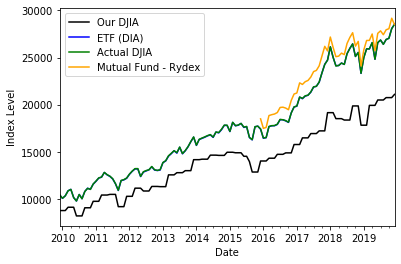

In [91]:
new_djia["Price Adjusted"].plot(label = 'Our DJIA', color = 'black')
etf_djia['Price Adjusted'].plot(label = 'ETF (DIA)', color = 'blue')
real_djia["prccm"].plot(label = 'Actual DJIA', color = 'green')
mutual['month nav'].plot(label = 'Mutual Fund - Rydex', color = 'orange')

xlabel('Date')
ylabel('Index Level')
legend(loc='best')

## Correlation of the 4 methods

In [95]:
# Correlation matrix between my S&P 500, the actual S&P 500 Index, a Mutual Fund, and an ETF
dj_price_corr = pd.DataFrame(data={"My DJIA":new_djia["Price Adjusted"], "Mutual Fund (rydhx)":mutual['month nav'], "Actual DJIA":real_djia["prccm"], "ETF (DIA)":etf_djia['Price Adjusted']})
dj_price_corr.corr()

,My DJIA,Mutual Fund (rydhx),Actual DJIA,ETF (DIA)
My DJIA,1.000000,0.963118,0.985508,0.985264
Mutual Fund (rydhx),0.963118,1.000000,0.996317,0.996351
Actual DJIA,0.985508,0.996317,1.000000,0.999995
ETF (DIA),0.985264,0.996351,0.999995,1.000000
